# 加载包

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import csv

import warnings
warnings.filterwarnings('ignore')

In [ ]:
traindatafilepath = "train.csv"
testdatafilepath = "test.csv"
traindata = pd.read_csv(traindatafilepath)
testdata = pd.read_csv(testdatafilepath)

train_X = traindata
train_y = traindata.SalePrice
full_data = pd.concat((train_X, testdata)).reset_index(drop=True).drop(["SalePrice"], axis=1)

In [ ]:
"""dummy variables & fill miss"""
for col in full_data.columns:
#     print(col, "\t", end="")
#     print(full_data[col].dtype, "\t", end="")
#     print(full_data[col].dtype == object)
    if full_data[col].dtype == object:
        categories = full_data[col].unique()
        categories = [i for i in categories if i == i]
#         print(categories)
        tmp_dict = {}
        idx = 1
        for cat in categories:
            tmp_dict[cat] = idx
            idx += 1
        full_data["_" + col] = full_data[col].map(tmp_dict)

serializecols = full_data.select_dtypes(include=[np.number]).columns  
serializeFullData = full_data[serializecols]

In [ ]:
"""fill nan data"""
for col in serializecols:
    serializeFullData[col].fillna(np.mean(serializeFullData[col]), inplace=True)

In [ ]:

traindata = pd.concat([serializeFullData[:len(train_y)], train_y], axis=1)
testdata = serializeFullData[len(train_y):]

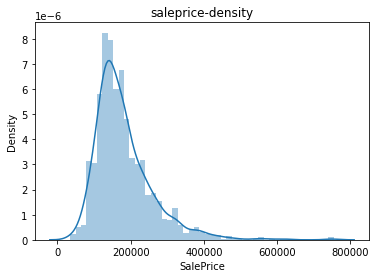

In [ ]:
SalePrice = traindata['SalePrice']
sns.distplot(SalePrice)
plt.title("saleprice-density")
plt.show()

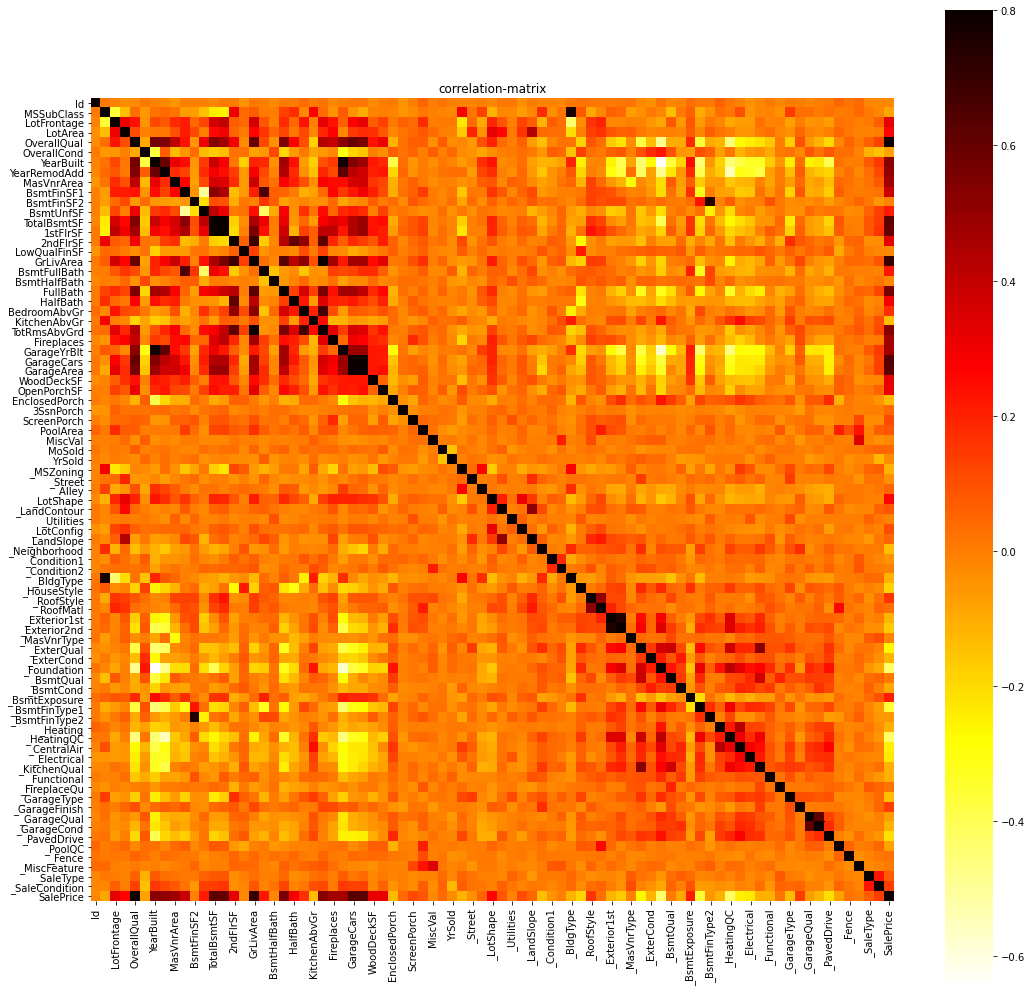

In [ ]:

correlation_matrix = traindata.corr()
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(correlation_matrix, vmax=0.8, cmap="hot_r", square=True)
plt.title("correlation-matrix")
plt.show()

In [ ]:

feature_name = correlation_matrix.columns
saleprice_feature = correlation_matrix.tail(1).values[0]
print(feature_name)
print(saleprice_feature)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', '_MSZoning', '_Street', '_Alley',
       '_LotShape', '_LandContour', '_Utilities', '_LotConfig', '_LandSlope',
       '_Neighborhood', '_Condition1', '_Condition2', '_BldgType',
       '_HouseStyle', '_RoofStyle', '_RoofMatl', '_Exterior1st',
       '_Exterior2nd', '_MasVnrType', '_ExterQual', '_ExterCond',
       '_Foundation', '_BsmtQual', '_BsmtCond', '_BsmtExposure',
       '_BsmtFinType1', '_BsmtFinType2', '_Heating', '_HeatingQ

In [ ]:

feature_corr_dict = {}
for i in range(len(feature_name)):
    feature_corr_dict[feature_name[i]] = saleprice_feature[i]


k = 10 

sorted_feature_corr_dict = sorted(feature_corr_dict.items(), key=lambda item:item[1], reverse=True)[:k]
print(sorted_feature_corr_dict)

[('SalePrice', 1.0), ('OverallQual', 0.7909816005838047), ('GrLivArea', 0.7086244776126511), ('GarageCars', 0.640409197258349), ('GarageArea', 0.6234314389183598), ('TotalBsmtSF', 0.6135805515591944), ('1stFlrSF', 0.6058521846919166), ('FullBath', 0.5606637627484452), ('TotRmsAbvGrd', 0.5337231555820238), ('YearBuilt', 0.5228973328794967)]


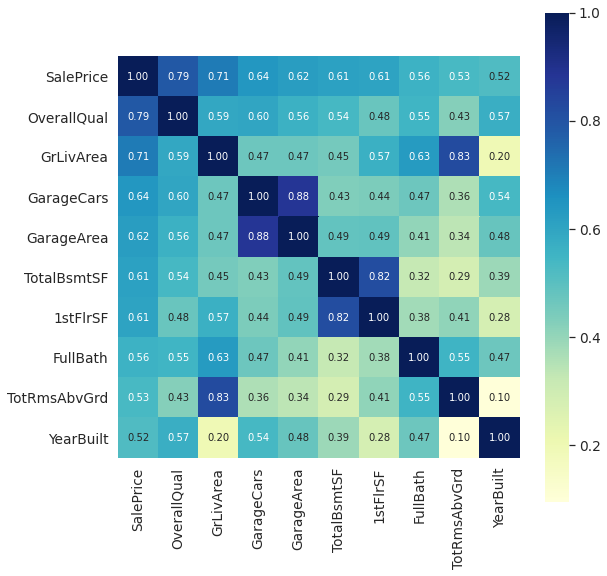

In [ ]:

cols = [line[0] for line in sorted_feature_corr_dict]
cm = np.corrcoef(traindata[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(9, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, cmap="YlGnBu",
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()

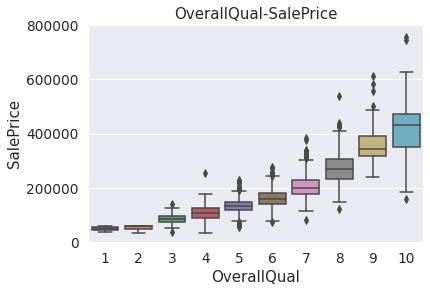

In [ ]:

data = pd.concat([traindata['SalePrice'], traindata['OverallQual']], axis=1)
fig = sns.boxplot(x="OverallQual", y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.title("OverallQual-SalePrice")
plt.show()

In [ ]:

print(cols)

['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']


In [ ]:
"""GradientBoostingRegressor"""
from sklearn.ensemble import GradientBoostingRegressor

def  housepricePrediction_GB(traindata, testdata, cols):
    selected_train_data_x = traindata[cols[1:k]]
    selected_train_data_y = traindata[cols[0]]
    selected_test_data_x = testdata[cols[1:k]]

    
    GB_model = GradientBoostingRegressor()
  
    GB_model.fit(selected_train_data_x, selected_train_data_y)

    predicted_prices = []
    for test_infos in tqdm.tqdm(selected_test_data_x.values):
        try:
            predicted_price = GB_model.predict([test_infos])[0]
            predicted_prices.append(predicted_price)
        except:
            predicted_prices.append(0)

    df_predicted_prices = pd.DataFrame(predicted_prices, columns=["SalePrice"])

    outputfilepath = r"GB_result_"+ str(k) +".csv"
    f = open(outputfilepath, 'w', newline='')
    csv_writer = csv.writer(f)
    csv_writer.writerow(["Id", "SalePrice"])
    ID = 1461
    for index, line in df_predicted_prices.iterrows():
        csv_writer.writerow([ID, line["SalePrice"]])
        ID += 1

    f.close()
    


In [ ]:
"""RandomForestRegressor"""
from sklearn.ensemble import RandomForestRegressor

def  housepricePrediction_RF(traindata, testdata, cols):
    selected_train_data_x = traindata[cols[1:k]]
    selected_train_data_y = traindata[cols[0]]
    selected_test_data_x = testdata[cols[1:k]]

 
    RF_model = RandomForestRegressor()
  
    RF_model.fit(selected_train_data_x, selected_train_data_y)

    predicted_prices = []
    for test_infos in tqdm.tqdm(selected_test_data_x.values):
        try:
            predicted_price = RF_model.predict([test_infos])[0]
            predicted_prices.append(predicted_price)
        except:
            predicted_prices.append(0)

    df_predicted_prices = pd.DataFrame(predicted_prices, columns=["SalePrice"])

    outputfilepath = r"RF_result_"+ str(k) +".csv"
    f = open(outputfilepath, 'w', newline='')
    csv_writer = csv.writer(f)
    csv_writer.writerow(["Id", "SalePrice"])
    ID = 1461
    for index, line in df_predicted_prices.iterrows():
        csv_writer.writerow([ID, line["SalePrice"]])
        ID += 1

    f.close()
    


In [ ]:
"""Lasso"""
from sklearn.linear_model import Lasso

def  housepricePrediction_Lasso(traindata, testdata, cols):
    selected_train_data_x = traindata[cols[1:k]]
    selected_train_data_y = traindata[cols[0]]
    selected_test_data_x = testdata[cols[1:k]]


    Lasso_model = Lasso()
    
    Lasso_model.fit(selected_train_data_x, selected_train_data_y)

    predicted_prices = []
    for test_infos in tqdm.tqdm(selected_test_data_x.values):
        try:
            predicted_price = Lasso_model.predict([test_infos])[0]
            predicted_prices.append(predicted_price)
        except:
            predicted_prices.append(0)

    df_predicted_prices = pd.DataFrame(predicted_prices, columns=["SalePrice"])

    outputfilepath = r"Lasso_result_"+ str(k) +".csv"
    f = open(outputfilepath, 'w', newline='')
    csv_writer = csv.writer(f)
    csv_writer.writerow(["Id", "SalePrice"])
    ID = 1461
    for index, line in df_predicted_prices.iterrows():
        csv_writer.writerow([ID, line["SalePrice"]])
        ID += 1

    f.close()
    


In [ ]:

housepricePrediction_GB(traindata, testdata, cols)
housepricePrediction_RF(traindata, testdata, cols)
housepricePrediction_Lasso(traindata, testdata, cols)

100%|██████████| 1459/1459 [00:00<00:00, 11452.58it/s]


In [ ]:
Lasso_model = Lasso()
a = "GB_result_31.csv"
b = "RF_result_31.csv"
gb = pd.read_csv(a)
rf = pd.read_csv(b)
test11= pd.DataFrame(gb["SalePrice"])
test22= pd.DataFrame(rf["SalePrice"])
blending=test11*0.6+test22*0.4
d=list(blending.iloc[:,0])
testdata["SalePrice"]=d
type(testdata)
testdata.to_csv("testdata.csv")